In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

from skforecast.recursive import ForecasterRecursive

In [3]:
# Electricity demand.
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)

df.drop(columns=["Industrial"], inplace=True)
# Print statement for training
print(df['Date'][:48], end="\n\n")




# Convert the integer Date to an actual date with datetime type
df["date"] = df["Date"].apply(
    lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days")
)
# Print statement for training
print(df['date'][:48], end="\n\n")




# Create a timestamp from the integer Period representing 30 minute intervals
df["date_time"] = df["date"] + \
    pd.to_timedelta((df["Period"] - 1) * 30, unit="m")
# Print statement for training    
print(df['date_time'][:48], end="\n\n")    




df.dropna(inplace=True)

# Rename columns
df = df[["date_time", "OperationalLessIndustrial"]]

df.columns = ["date_time", "demand"]

# Resample to hourly
df = (
    df.set_index("date_time")
    .resample("h")
    .agg({"demand": "sum"})
)

#df.head()

0     37257
1     37257
2     37257
3     37257
4     37257
5     37257
6     37257
7     37257
8     37257
9     37257
10    37257
11    37257
12    37257
13    37257
14    37257
15    37257
16    37257
17    37257
18    37257
19    37257
20    37257
21    37257
22    37257
23    37257
24    37257
25    37257
26    37257
27    37257
28    37257
29    37257
30    37257
31    37257
32    37257
33    37257
34    37257
35    37257
36    37257
37    37257
38    37257
39    37257
40    37257
41    37257
42    37257
43    37257
44    37257
45    37257
46    37257
47    37257
Name: Date, dtype: int64

0    2002-01-01
1    2002-01-01
2    2002-01-01
3    2002-01-01
4    2002-01-01
5    2002-01-01
6    2002-01-01
7    2002-01-01
8    2002-01-01
9    2002-01-01
10   2002-01-01
11   2002-01-01
12   2002-01-01
13   2002-01-01
14   2002-01-01
15   2002-01-01
16   2002-01-01
17   2002-01-01
18   2002-01-01
19   2002-01-01
20   2002-01-01
21   2002-01-01
22   2002-01-01
23   2002-01-01
24   2002-01-0

In [4]:
#1: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import root_mean_squared_error
from feature_engine.datetime import DatetimeFeatures
from skforecast.recursive import ForecasterRecursive

In [5]:
#2: Load data
url = "https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv"
df = pd.read_csv(url)
df.to_csv("example_retail_sales.csv", index=False)
df = pd.read_csv(
    "example_retail_sales.csv",
    parse_dates=["ds"],
    index_col=["ds"],
    nrows=160,
)
df = df.asfreq("MS")
df.head()

,y
ds,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


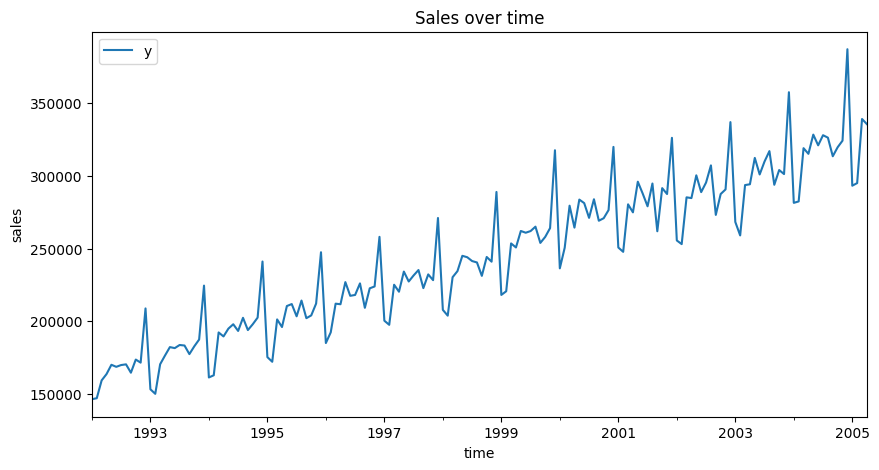

In [6]:
#Plot time series
fig, ax = plt.subplots(figsize=(10, 5))
df.plot(ax=ax)
ax.set_title('Sales over time')
ax.set_xlabel('time')
ax.set_ylabel('sales')
ax.legend(['y'])
plt.show()

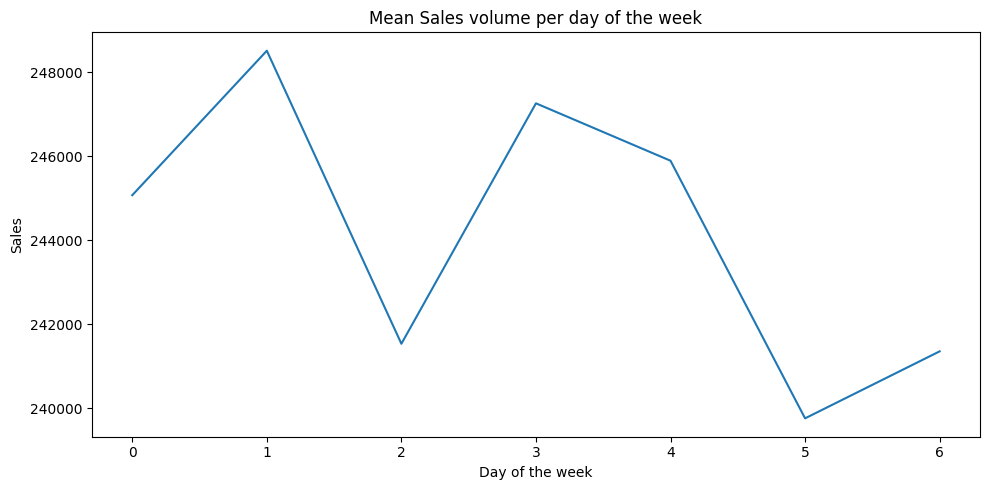

In [7]:
# Seasonality
# 1. define time component like day in this example
# 2. groupby said component and take the mean, define a variable to store the groupby, 
# like in this case group mean.
# 3. plot the new grouped mean.
day = df.index.dayofweek

grouped_mean = df.groupby(day).mean(numeric_only=True)['y']
fig, ax = plt.subplots(figsize=(10, 5))
grouped_mean.plot(ax=ax)
ax.set_xlabel('Day of the week')
ax.set_ylabel('Sales')
ax.set_title('Mean Sales volume per day of the week')
plt.tight_layout()


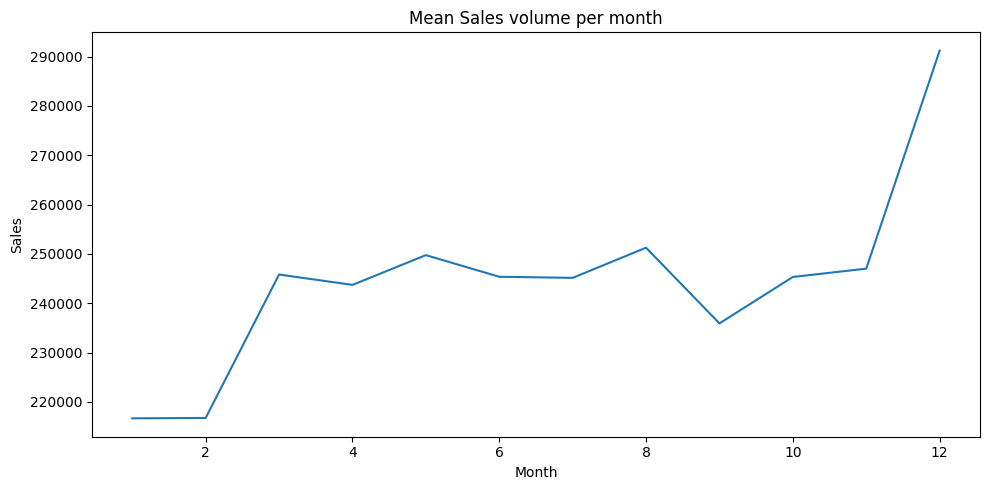

In [8]:
month = df.index.month
grouped_mean = df.groupby(month).mean(numeric_only=True)['y']
fig, ax = plt.subplots(figsize=(10, 5))
grouped_mean.plot(ax=ax)
ax.set_title('Mean Sales volume per month')
ax.set_xlabel('Month')
ax.set_ylabel('Sales')
plt.tight_layout()

In [9]:
# Split the data
end_train = '2003-12-31'
X_train = df.loc[:end_train]
X_test = df.loc[end_train:]

In [10]:
X_train.tail()

,y
ds,
2003-08-01,317056
2003-09-01,293890
2003-10-01,304036
2003-11-01,301265
2003-12-01,357577


In [11]:
X_train.head()

,y
ds,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


In [12]:
#Set up regression model

model = Pipeline([
    ("scaler", MinMaxScaler()),
    ("Lasso", Lasso(random_state=9, alpha=10))
])

In [13]:
# input to the datetime features

# the index needs to match with the series we
# want to forecast

datetime_df = pd.DataFrame(
    X_train.index,
    index=X_train.index,
)
datetime_df

,ds
ds,
1992-01-01,1992-01-01
1992-02-01,1992-02-01
1992-03-01,1992-03-01
1992-04-01,1992-04-01
1992-05-01,1992-05-01
...,...
2003-08-01,2003-08-01
2003-09-01,2003-09-01
2003-10-01,2003-10-01


In [14]:
datetime_f = DatetimeFeatures(
    variables="ds",
    features_to_extract=["month", "day_of_week"],
    drop_original=True,
)


In [15]:
forecaster = ForecasterRecursive(
    regressor=model,
    lags=12,
    transformer_exog=datetime_f,
    forecaster_id="recursive"
)

In [16]:
forecaster.fit(
    y=X_train["y"],
    exog=datetime_df
)
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: Pipeline 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Window features: None 
Window size: 12 
Exogenous included: True 
Exogenous names: ds 
Transformer for y: None 
Transformer for exog: DatetimeFeatures(features_to_extract=['month', 'day_of_week'], variables='ds') 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1992-01-01 00:00:00'), Timestamp('2003-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'scaler__clip': False, 'scaler__copy': True, 'scaler__feature_range': (0, 1),
    'Lasso__alpha': 10, 'Lasso__copy_X': True, 'Lasso__fit_intercept': True,
    'Lasso__max_iter': 1000, 'Lasso__positive': False, 'Lasso__precompute':
    False, 'Lasso__random_state': 9, 'Lasso__selection': 'cyclic', 'Lasso__tol':
    0.0001, 'Lasso__warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-02-02 21:38:25 
Last fit date: 2025-02-02 21:38:25 
Skforecast version: 0.14.0 
Python version: 3.12.6 
Forecaster id: recursive

In [17]:
# Check the predictor features table created by skforecast.

# These are the input to the Lasso, so it's important to know
# what we are using for training:

X, y = forecaster.create_train_X_y(
    y=X_train["y"],
    exog=datetime_df,
)

X, y

(               lag_1     lag_2     lag_3     lag_4     lag_5     lag_6  \
 ds                                                                       
 1993-01-01  208838.0  171547.0  173655.0  164617.0  170364.0  169890.0   
 1993-02-01  153221.0  208838.0  171547.0  173655.0  164617.0  170364.0   
 1993-03-01  150087.0  153221.0  208838.0  171547.0  173655.0  164617.0   
 1993-04-01  170439.0  150087.0  153221.0  208838.0  171547.0  173655.0   
 1993-05-01  176456.0  170439.0  150087.0  153221.0  208838.0  171547.0   
 ...              ...       ...       ...       ...       ...       ...   
 2003-08-01  309923.0  300998.0  312389.0  294251.0  293693.0  259051.0   
 2003-09-01  317056.0  309923.0  300998.0  312389.0  294251.0  293693.0   
 2003-10-01  293890.0  317056.0  309923.0  300998.0  312389.0  294251.0   
 2003-11-01  304036.0  293890.0  317056.0  309923.0  300998.0  312389.0   
 2003-12-01  301265.0  304036.0  293890.0  317056.0  309923.0  300998.0   
 
                lag_7  

In [18]:
# forecast next 3 months
#Predict the first 3 months of sales right after the training set.
#That is, starting on `2002-01-01`.

# we need to create the table with datetime from
# which the datetime features will be created:

# this date needs to coincide with the forecasting
# horizon


datetime_df_test = pd.DataFrame(
    X_test.head(3).index,
    index=X_test.head(3).index,
)

datetime_df_test.head()

,ds
ds,
2004-01-01,2004-01-01
2004-02-01,2004-02-01
2004-03-01,2004-03-01


In [19]:
# Predict the next 24 hs

predictions = forecaster.predict(
    steps=3,
    exog=datetime_df_test,
)

predictions.head()

2004-01-01    284034.022826
2004-02-01    268854.147268
2004-03-01    308677.758494
Freq: MS, Name: pred, dtype: float64

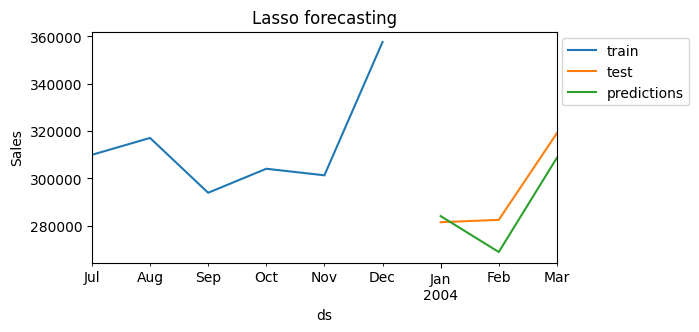

In [20]:
fig, ax = plt.subplots(figsize=(6, 3))
X_train.tail(6)["y"].plot(ax=ax, label='train')
X_test.head(3)["y"].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
plt.title("Lasso forecasting")
plt.ylabel("Sales")
ax.legend(bbox_to_anchor=(1.3, 1.0));

In [21]:
# Predoctopm error

error_rmse = root_mean_squared_error(
    y_true = X_test["y"].head(3),
    y_pred = predictions,
)
print(f"Test error (rmse): {error_rmse}")

Test error (rmse): 9990.89443258819


In [22]:
#Forecast future data
forecast_start = '2004-12-31'
# we need sales up to 12 months before this point
# because we are using a lag of 12
past_data_available = X_test[:forecast_start].tail(12)
# data in the past that we know at the point of forecast
past_data_available.shape

(12, 1)

In [23]:
# we also need the datetime in the date 
# range of the forecasting horizon.

# To make predictions `exog` must start 
# one step ahead of `last_window`.

horizon = X_test[forecast_start:].head(3)
datetime_df_test = pd.DataFrame(
    horizon.index,
    index=horizon.index,
)

datetime_df_test

,ds
ds,
2005-01-01,2005-01-01
2005-02-01,2005-02-01
2005-03-01,2005-03-01


In [24]:
predictions = forecaster.predict(
    steps=3,
    last_window=past_data_available["y"],
    exog=datetime_df_test,
)
predictions

2005-01-01    294427.375181
2005-02-01    295468.556623
2005-03-01    330646.433602
Freq: MS, Name: pred, dtype: float64

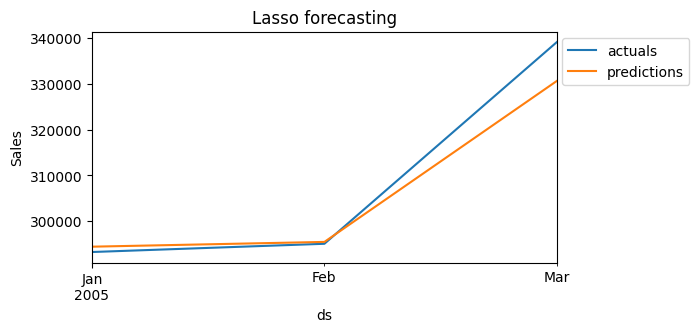

In [25]:
# Plot the forecast vs the actual
fig, ax = plt.subplots(figsize=(6, 3))
horizon["y"].plot(ax=ax, label='actuals')
predictions.plot(ax=ax, label='predictions')
plt.title("Lasso forecasting")
plt.ylabel('Sales')
ax.legend(bbox_to_anchor=(1.3, 1.0));

In [26]:
# RMSE
error_rmse = root_mean_squared_error(
    y_true = X_test["y"].head(3),
    y_pred = predictions,
)
print(f"Test error (rmse): {error_rmse}")

Test error (rmse): 12538.523147580763


In [30]:
df[f"y_lag_1"] = df['y'].shift(periods=1)
df[f"y_lag_24"] = df['y'].shift(freq='24h')